In [4]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import collections as cl


[0.94678423 1.07136111 1.08564592 1.10031681 1.10031681 1.16987707]
[1.45 1.2  1.2  1.2  1.2  1.2 ]


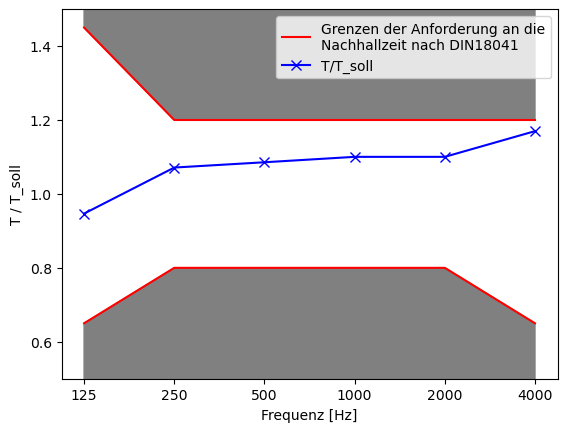

In [1]:


volume = 40 # Abschaetzung eines normal grossen Raumes
surface = [20,20,10,10,8,8] # Abschaetzung eines normal grossen Raumes
# Testwerte fuer die diffusen Absorptionsgrade
alpha_d = {'125 Hz': [0.1, 0.1,0.2, 0.1,0.1, 0.1], '250 Hz': [0.1, 0.1,0.1, 0.1,0.1, 0.1], 
           '500 Hz': [0.02, 0.1,0.2, 0.07,0.1, 0.2], '1 kHz': [0.1, 0.1, 0.08, 0.1,  0.1, 0.1], 
           '2 kHz': [0.1, 0.04, 0.1, 0.2, 0.1, 0.1], '4 kHz': [0.1, 0.1, 0.1, 0.1, 0.02, 0.1]} # 
power = 10 * 10**(-7) # Mittelwert Unterhaltungssprache nach Tabelle 5.2 im Skript technische Akustik
distance = 3
use = 'Musik'

class Raum: 
    def __init__(self, volume, surface, alpha_d, power, distance, use):
        self.input = {'Volume': volume, 'Surface': surface, 'Absorption coefficient': alpha_d,
                       'Source pwoer': power, 'Distance source <-> receiver': distance}
        self.volume = volume
        self.surface = surface
        self.alpha_d = alpha_d
        self.power = power
        self.distance = distance
        self.use = use
    
    def eq_a(self):
        # surface als list mit m^2 der einzelnen Waende
        # alpha_d als dictionary mit Oktavbandfrequenzen als key und Liste der diffusen Absorptionsgrade pro Wand als value   
        A = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }

        for j in range(len(self.surface)):
            for i in A:
                X = self.alpha_d[i]
                A[i] = A[i] + self.surface[j] * X[j]
 
        return A
   
    def nachhallzeit(self):
        RT = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
        A = self.eq_a()
        for i in A:
            RT[i] = (self.volume / A[i]) * 0.161
        return RT
    
    def level_diffuse(self):
        L_R = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
        A = self.eq_a()
        for i in self.alpha_d:
            L_R[i] = 10 * math.log10(power / 10**(-12)) - 10 * math.log10(A[i]) + 6
        return L_R
    
    def level_direct(self):
        L_D = 7#10 * math.log10(self.power / 10**(-12)) - 10 * math.log10(4 * np.pi * self.distance**2)
        return L_D

    def hallradius(self):
        distance = 10**(-10)
        L_R = self.level_diffuse()
        L_D = self.level_direct()

        L_Rm = 0 # Initalisierung fuer Mittelwert des reflektierten Schalldruckpegels ueber alle Oktavbaender
        # Mittelwertbildung des reflektierten Schalldruckpegels
        for i in L_R:
            L_Rm = L_Rm + L_R[i] 
        L_Rm = L_Rm / len(L_R)
        # Sobald Mittelwert des reflektierten Schalldruckpegels
        # groesser als direkter Schalldruckpegel ist wird Hallradius ausgegeben
        while L_Rm < L_D:
            self.distance = self.distance + 0.01
            L_D = self.level_direct()            
        return self.distance 
    
    def sprachverstaendlichkeit(self):
        T_Vergleich = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
        T_upperlimit = {'125 Hz':1.45 , '250 Hz':1.2 , '500 Hz':1.2 , '1 kHz':1.2, '2 kHz':1.2 , '4 kHz':1.2 }
        T_lowerlimit = {'125 Hz':0.65 , '250 Hz':0.8 , '500 Hz':0.8 , '1 kHz':0.8, '2 kHz':0.8 , '4 kHz':0.65 }

        # Pruefung welchen use (welche Nutzungsart nach DIN 18041) vorliegt und Berechnung der Soll-Nachhallzeit abhaengig vom Raumvolumen
        if self.use == 'Musik':
            # Pruefung, ob das Volumen nach DIN 18041 fuer Nutzungsart zugelassen ist
            # Falls es nicht passend ist wird T_Vergleich 0 gesetzt, damit im Folgenden auch die Funktion plot_nachhallzeit beendet werden kann ohne, dass es zu Fehlern kommt
            # Ansonsten wird einfach die T_soll ausgerechnet 
            while True:
                if self.volume < 30:
                    print(f'Volumen ist mit {self.volume} m^3 zu klein für die Berechnung nach DIN 18041 mit der Nutzungsart "Musik"')
                    T_Vergleich = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
                    return T_Vergleich
                elif self.volume > 1000:        
                    print(f'Volumen ist mit {self.volume} m^3 zu groß für die Berechnung nach DIN 18041 mit der Nutzungsart "Musik"')
                    T_Vergleich = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
                    return T_Vergleich
                else:    
                    T_soll = 0.45 * math.log10(self.volume) + 0.07
                    break
                

        elif self.use == 'Sprache/Vortrag':
            while True:
                if self.volume < 50:
                    print(f'Volumen ist mit {self.volume} m^3 zu klein für die Berechnung nach DIN 18041 mit der Nutzungsart "Sprache/Vortrag"')
                    T_Vergleich = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
                    return T_Vergleich
                elif self.volume > 5000:        
                    print(f'Volumen ist mit {self.volume} m^3 zu groß für die Berechnung nach DIN 18041 mit der Nutzungsart "Sprache/Vortrag"')
                    T_Vergleich = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
                    return T_Vergleich
                else:    
                    T_soll = 0.37 * math.log10(self.volume) - 0.14
                    break

        elif self.use == 'Sprache/Vortrag inklusiv':
            while True:
                if self.volume < 30:
                    print(f'Volumen ist mit {self.volume} m^3 zu klein für die Berechnung nach DIN 18041 mit der Nutzungsart "Sprache/Vortrag inklusiv"')
                    T_Vergleich = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
                    return T_Vergleich
                elif self.volume > 5000:        
                    print(f'Volumen ist mit {self.volume} m^3 zu groß für die Berechnung nach DIN 18041 mit der Nutzungsart "Sprache/Vortrag inklusiv"')
                    T_Vergleich = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
                    return T_Vergleich
                else:    
                    T_soll = 0.32 * math.log10(self.volume) - 0.17
                    break

        elif self.use == 'Unterricht/Kommunikation':
            while True:
                if self.volume < 30:
                    print(f'Volumen ist mit {self.volume} m^3 zu klein für die Berechnung nach DIN 18041 mit der Nutzungsart "Unterricht/Kommunikation"')
                    T_Vergleich = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
                    return T_Vergleich
                elif self.volume > 1000:        
                    print(f'Volumen ist mit {self.volume} m^3 zu groß für die Berechnung nach DIN 18041 mit der Nutzungsart "Unterricht/Kommunikation"')
                    T_Vergleich = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
                    return T_Vergleich
                else:
                    T_soll = 0.32 * math.log10(self.volume) - 0.17

        elif self.use == 'Unterricht/Kommunikation inklusiv':
            while True:
                if self.volume < 30:
                    print(f'Volumen ist mit {self.volume} m^3 zu klein für die Berechnung nach DIN 18041 mit der Nutzungsart "Unterricht/Kommunikation inklusiv"')
                    T_Vergleich = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
                    return T_Vergleich
                elif self.volume > 500:        
                    print(f'Volumen ist mit {self.volume} m^3 zu groß für die Berechnung nach DIN 18041 mit der Nutzungsart "Unterricht/Kommunikation inklusiv"')
                    T_Vergleich = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
                    return T_Vergleich
                else:
                    T_soll = 0.26 * math.log10(self.volume) - 0.14

        elif self.use == 'Sport':
            while True:
                if self.volume < 200:
                    print(f'Volumen ist mit {self.volume} m^3 zu klein für die Berechnung nach DIN 18041 mit der Nutzungsart "Sport"')
                    T_Vergleich = {'125 Hz':0 , '250 Hz':0 , '500 Hz':0 , '1 kHz':0, '2 kHz':0 , '4 kHz':0 }
                    return T_Vergleich
                elif self.volume > 10000:        
                    T_soll = 2
                    break
                else:
                    T_soll = 0.75 * math.log10(self.volume) - 1
                    break

        # Berechnung des Quotienten RT/RT_soll und Pruefung, ob berechnete Nachhallzeit in den Fehlerschranken nach Abbildung 2 in DIN 18041 liegt
        for i in self.nachhallzeit():
            T_Vergleich[i] = self.nachhallzeit()[i] / T_soll
            if T_Vergleich[i] > T_upperlimit[i]:
                print(f'Nachhallzeit in Oktavband mit Mittenfrequenz {i} zu hoch')
            elif T_Vergleich[i] < T_lowerlimit[i]:
                print(f'Nachhallzeit in Oktavband mit Mittenfrequenz {i} zu niedrig')      
        return T_Vergleich
    
    def plot_nachhallzeit(self):
        freq = np.array([125,250,500,1000,2000,4000])
        # Upper und lower limit bezieht sich auf die Fehlerschranken
        T_upperlimit = {'125 Hz':1.45 , '250 Hz':1.2 , '500 Hz':1.2 , '1 kHz':1.2, '2 kHz':1.2 , '4 kHz':1.2}
        T_lowerlimit = {'125 Hz':0.65 , '250 Hz':0.8 , '500 Hz':0.8 , '1 kHz':0.8, '2 kHz':0.8 , '4 kHz':0.65}

                
        T_Vergleich = np.array(list(self.sprachverstaendlichkeit().values()))

        # Wenn Volumen nicht passend fuer Nutzungsart wird in der Funktion sprachverstaendlichkeit T_Vergleich zu Null gesetzt, damit wird hier auch die Funktion plot_nachhallzeit beendet
        if np.average(T_Vergleich) == 0:
            return 
        
        # Werte fuer Y-Achsen grenzen - abhaengig von dem Maximal- / Minimalwert
        maxgrey = max(T_Vergleich) + 0.2
        mingrey = min(T_Vergleich) - 0.2
        T_ul = np.array(list(T_upperlimit.values()))
        T_ll = np.array(list(T_lowerlimit.values()))

        print(T_Vergleich)
        print(T_ul)

        fig, ax = plt.subplots()
        ax.plot(freq, T_ul, color='r',label = 'Grenzen der Anforderung an die\nNachhallzeit nach DIN18041 ')
        ax.plot(freq, T_ll, color='r')
        ax.plot(freq, T_Vergleich, label = 'T/T_soll', marker = 'x', color = 'blue',markersize = 7)
        ax.fill_between(freq, T_ul, 10, color = 'grey')
        ax.fill_between(freq, T_ll, -10, color = 'grey')
        ax.set_xscale('log', base=2) 


     
    
        # y Achsen limits in abhangigkeit von der berechneten Nachhallzeit
        if (T_Vergleich > T_ul).any(): 
            ax.set_ylim([min(T_ll) - 0.2, maxgrey])
            print('test RT gross')
        elif (T_Vergleich < T_ll).any():   #max(list(T_Vergleich)) < max(list(T_upperlimit.values())): # grosster Wert in T_Vergleich ist kleiner als der groesste Wert der unteren Grenze
            ax.set_ylim([mingrey, max(T_ul) + 0.2])
            print('test')
        else:
            ax.set_ylim([0.5, 1.5])

        # Achsenformatierung fuer log basis 2        
        ax.xaxis.set_major_locator(ticker.LogLocator(base=2.0))
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
        xticks = np.array(freq)
        ax.set_xticks(xticks)
        ax.set_xlabel('Frequenz [Hz]')
        ax.set_ylabel('T / T_soll')
        ax.legend()
        plt.show()
        return 
    
Raum_1 = Raum(volume , surface, alpha_d, power, distance, use)

Raum_1.plot_nachhallzeit()




In [54]:
l1 = np.array([1,2,3,4])
l2 = np.array([.9,2,3,.9])

if (l2 < l1).any():
    print('test')

# np.arange(4)

test


In [12]:
areas = 6.0
area =  np.linspace(0,int(areas),int(areas)+1)
print(area)
for i in enumerate(area):
    print(i)

[0. 1. 2. 3. 4. 5. 6.]
(0, 0.0)
(1, 1.0)
(2, 2.0)
(3, 3.0)
(4, 4.0)
(5, 5.0)
(6, 6.0)
